In [ ]:
# instala dependências extras

!pip install torch --index-url https://download.pytorch.org/whl/cpu

In [1]:
# importa as libs
import os
import sys
from utils.utils import *
from utils.bert_review_dataset import *

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support

import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline

c:\Users\Wectornanime\Workspace\GitHub\analysis_disneyland_reviews\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Baixar recursos NLTK

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

In [2]:
# configuração

dataset_uri = './database/DisneylandReviews.csv'
dataset_encoding = 'latin1'

pre_trined_model = 'MarieAngeA13/Sentiment-Analysis-BERT'

supervised_training_repetitions = 10

supervised_training_models = {
  'MLP': MLPClassifier(hidden_layer_sizes=(100), max_iter=500, random_state=42),
  'SVM': SVC(kernel='linear', random_state=42)
}

approval_size = 0.1 # 10% para homologação

# configura a seed aleatória para os modelos supervisionados
np.random.seed(19)

In [3]:
# importa o dataset
df = pd.read_csv(dataset_uri, encoding=dataset_encoding)

## Análise e Tratamento de Dados (EDA)

In [4]:
# primeiras linhas do dataset
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [5]:
# informações da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [6]:
# verificação de valores nulos
df.isnull().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64

In [7]:
df['Rating'].value_counts()

Rating
5    23146
4    10775
3     5109
2     2127
1     1499
Name: count, dtype: int64

## Preparar o Rótulo (Sentimento)

In [8]:
# cria uma coluna chamada 'Sentiment'
df['Sentiment'] = df['Rating'].apply(get_sentiment)
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Sentiment
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,positive
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,positive
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,positive
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,positive
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,positive


In [9]:
# separa o df para treino e testes

df_treino, df_teste = train_test_split(df, test_size=approval_size, random_state=42)

In [10]:
# separa as colunas que queremos trabalhar
df_treino = df_treino[['Review_Text', 'Sentiment']]
df_treino.head()

,Review_Text,Sentiment
35355,Fabulous time with the family during August. V...,positive
34977,This is my forth time at Disneyland Main Par...,negative
42216,We were very excited to have an opportunity to...,neutral
41388,I have just come back from Dance Camp (inclu...,neutral
26010,Rides for every age. My grandson loved starwar...,positive


## Pré-processamento de Texto

In [11]:
# Inicializa o lematizador e stopwords

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [12]:
# Inicializa a função responsável por fazer o pré-processamento de texto

def preprocess_text(text):
    # Converte para minúsculas
    text = text.lower()
    # Remove tudo que não for letra
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokeniza
    tokens = text.split()
    # tokens = word_tokenize(text) # o recurso punkt esta dando erro
    # Remove stopwords e lemmatiza
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)



In [13]:
# Aplica o pré-processamento na coluna 'Review_Text'
df_treino['Processed_Review'] = df_treino['Review_Text'].apply(preprocess_text)

df_treino[['Review_Text', 'Processed_Review']].head()

,Review_Text,Processed_Review
35355,Fabulous time with the family during August. V...,fabulous time family august hot busy park fast...
34977,This is my forth time at Disneyland Main Par...,forth time disneyland main park certainly last...
42216,We were very excited to have an opportunity to...,excited opportunity visit disney paris husband...
41388,I have just come back from Dance Camp (inclu...,come back dance camp includes sing camp euro d...
26010,Rides for every age. My grandson loved starwar...,ride every age grandson loved starwars really ...


## Extração de Features

In [14]:
# define X e y
X = df_treino['Processed_Review']
y = df_treino['Sentiment']

### Modelos Supervisionados Tradicionais (com TF-IDF)

In [15]:
# listas com as métricas

accuracy = {}
precision = {}
recall = {}
f1 = {}
confusion = {}

all_precision = {}
all_recall = {}
all_accuracy = {}

In [16]:
# função de treino

def train_models():
  # Dividir os dados em treino e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  # usando TF-IDF
  vectorizer = TfidfVectorizer(max_features=5000)
  X_train = vectorizer.fit_transform(X_train)
  X_test = vectorizer.transform(X_test)

  for name, model in supervised_training_models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    all_precision[name].append(precision_score(y_test, pred, average='weighted'))
    all_recall[name].append(recall_score(y_test, pred, average='weighted'))
    all_accuracy[name].append(accuracy_score(y_test, pred))

## Modelagem e Classificação

### Modelos Supervisionados Tradicionais (com TF-IDF)

In [17]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
# usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [20]:
# MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

accuracy['mlp'] = accuracy_score(y_test, y_pred_mlp)
precision['mlp'] = precision_score(y_test, y_pred_mlp, average='weighted')
recall['mlp'] = recall_score(y_test, y_pred_mlp, average='weighted')
f1['mlp'] = f1_score(y_test, y_pred_mlp, average='weighted')
confusion['mlp'] = confusion_matrix(y_test, y_pred_mlp)

In [ ]:
# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy['svm'] = accuracy_score(y_test, y_pred_svm)
precision['svm'] = precision_score(y_test, y_pred_svm, average='weighted')
recall['svm'] = recall_score(y_test, y_pred_svm, average='weighted')
f1['svm'] = f1_score(y_test, y_pred_svm, average='weighted')
confusion['svm'] = confusion_matrix(y_test, y_pred_svm)

## Trinamento dos modelos

In [ ]:
# treina os modelos supervisionados

for i in range(supervised_training_repetitions):
  train_models()

  # barra de progresso
  percent = (i + 1) / supervised_training_repetitions
  bar = '#' * int(50 * percent) + '-' * (50 - int(50 * percent))

  sys.stdout.write(f'\r[{bar}] {int(percent * 100)}%')
  sys.stdout.flush()

#### Resultados:

In [ ]:
# Exibir as métricas dos modelos
print('Média das métricas dos modelos:')

print('Precisão:')
for k, v in all_precision.items():
  print(f'{k}: {np.mean(v):.4f}')

print('Recall:')
for k, v in all_recall.items():
  print(f'{k}: {np.mean(v):.4f}')

print('Acurácia:')
for k, v in all_accuracy.items():
  print(f'{k}: {np.mean(v):.4f}')

In [ ]:
# tabela com os resultados

models_list = list(supervised_training_models.keys())

pd.DataFrame({
    'Modelo': models_list,
    'Precisão Média': [np.mean(all_precision[model_name]) for model_name in models_list],
    'Recall Médio': [np.mean(all_recall[model_name]) for model_name in models_list],
    'Acurácia Média': [np.mean(all_accuracy[model_name]) for model_name in models_list]
})

In [ ]:
# Exibe os valores da precisão em gráfico

plt.title('Gráfico da precisão dos modelos')

for name, value in all_precision.items():
  plt.plot(value, label=name)

# Adicionando título e rótulos aos eixos
plt.xlabel('Interação')
plt.ylabel('Valor')

# Adicionando a legenda para identificar as linhas
plt.legend()

# Aqui força o eixo X a mostrar apenas inteiros
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Ajusta os números para 3 casas decimais
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# Exibindo o gráfico
plt.show()

In [ ]:
# Exibe os valores da recall em gráfico

plt.title('Gráfico do recall dos modelos')

for name, value in all_recall.items():
  plt.plot(value, label=name)

# Adicionando título e rótulos aos eixos
plt.xlabel('Interação')
plt.ylabel('Valor')

# Adicionando a legenda para identificar as linhas
plt.legend()

# Aqui força o eixo X a mostrar apenas inteiros
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Ajusta os números para 3 casas decimais
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# Exibindo o gráfico
plt.show()

In [ ]:
# Exibe os valores da acurácia em gráfico

plt.title('Gráfico da acurácia dos modelos')

for name, value in all_accuracy.items():
  plt.plot(value, label=name)

# Adicionando título e rótulos aos eixos
plt.xlabel('Interação')
plt.ylabel('Valor')

# Adicionando a legenda para identificar as linhas
plt.legend()

# Aqui força o eixo X a mostrar apenas inteiros
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Ajusta os números para 3 casas decimais
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# Exibindo o gráfico
plt.show()

#### Exporta os modelos

In [ ]:
if not os.path.exists('exports'):
  os.makedirs('exports')

for name, model in supervised_training_models.items():
  with open(f'exports/model_{name}.pkl', 'wb') as file:
    pickle.dump({'model': model, 'vectorizer': vectorizer}, file)

### Modelo Pré-treinado (BERT)



In [21]:
sentiment_pipeline = pipeline(model=pre_trined_model)

Device set to use cpu


In [26]:
sentiment_pipeline("Its Disneyland! But don't have happy")

[{'label': 'negative', 'score': 0.8375328779220581}]

## Comparação entre os modelos

In [22]:
# seleciona o modelo supervisionado

supervised_model = mlp_model

In [23]:
# separar os dados

X_approval = df_teste['Review_Text']
y_approval = df_teste['Sentiment']

In [24]:
# Supervisionado

# vetoriza
X_test_vectorized = vectorizer.transform(X_approval)

# predição
y_pred_supervised = supervised_model.predict(X_test_vectorized)

In [ ]:
# Bert

bert_results = sentiment_pipeline(X_approval.tolist(), truncation=True)

# Extrair o rótulo da chave 'label'
y_pred_bert = [res['label'] for res in bert_results]

### Resultado

In [ ]:
models_approval = ['Supervisionado', 'Bert']

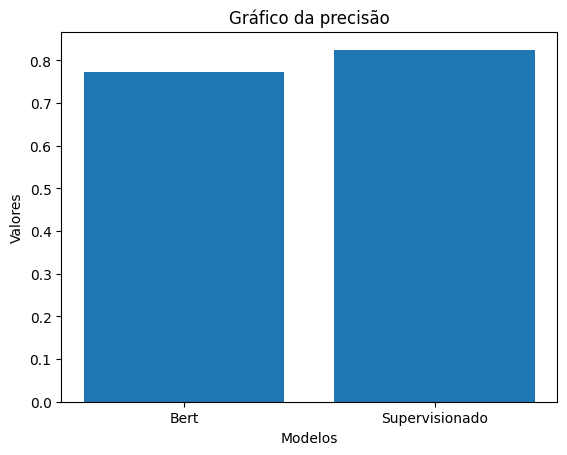

In [38]:
# precisão em gráfico de barras

precision_approval = [
  precision_score(y_approval, y_pred_supervised, average='weighted'),
  precision_score(y_approval, y_pred_bert, average='weighted')
]

plt.title('Gráfico da precisão')
plt.bar(models_approval, precision_approval)
plt.xlabel('Modelos')
plt.ylabel('Valores')

plt.show()

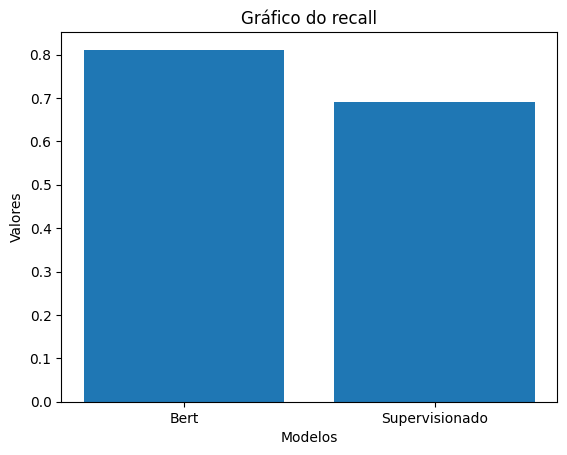

In [37]:
# recall em gráfico de barras

recall_approval = [
  recall_score(y_approval, y_pred_supervised, average='weighted'),
  recall_score(y_approval, y_pred_bert, average='weighted')
]

plt.title('Gráfico do recall')
plt.bar(models_approval, recall_approval)
plt.xlabel('Modelos')
plt.ylabel('Valores')

plt.show()

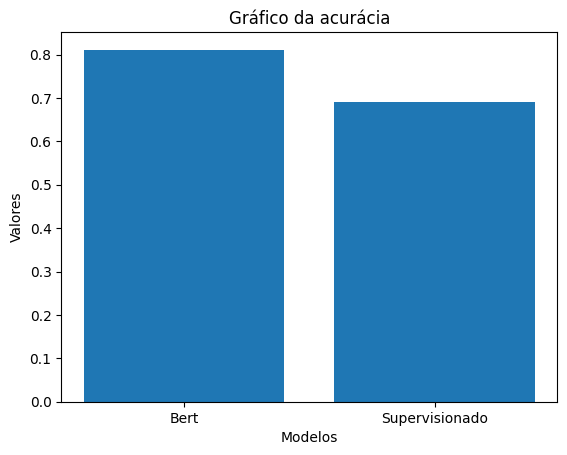

In [33]:
# acurácia em gráfico de barras

accuracy_approval = [
  accuracy_score(y_approval, y_pred_supervised),
  accuracy_score(y_approval, y_pred_bert)
]

plt.title('Gráfico da acurácia')
plt.bar(models_approval, accuracy_approval)
plt.xlabel('Modelos')
plt.ylabel('Valores')

plt.show()